In [0]:
import requests, zipfile, io
import pandas as pd
import csv
import seaborn as sn
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
from time import process_time
from copy import deepcopy 

In [0]:
# Get the source file
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00288/leaf.zip';
r = requests.get(url)
if r.ok:
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall('uci_leaf')

In [0]:
# Read source file
leafs = np.genfromtxt('uci_leaf/leaf.csv', delimiter=',')
X = leafs[:, 2:]
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X) 
y = leafs[:,0]

Codes for part 3 and part 4: They both use same functions.

In [0]:
def multi_to_binary(y, selected_label_id):
  y = y == selected_label_id  
  y = y.astype(int)
  return y

In [0]:
def print_confusion_matrices(matrix, labels, h=15, w=15):
  fig, ax = plt.subplots(figsize=(h,w))
  df_cm = pd.DataFrame(matrix, index=labels, 
                      columns=labels)

  ax= plt.subplot()
  sn.heatmap(df_cm, annot=True, ax = ax, fmt='g', cmap='Blues')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels);

In [0]:
# roc plot and confusion matrix for one vs rest
def k_fold_svm_ovr(X, y, k, kernel, selected_label_id=11, selected_label=[], C=1, degree=None, gamma=None):
  '''
    selected_label_id=11:
      class id of acer palmatum which has the max. number of specimens in dataset
  '''
  y_bin = multi_to_binary(deepcopy(y), selected_label_id)
  tprs = []
  aucs = []
  cms = [[0, 0], [0, 0]]
  mean_fpr = np.linspace(0, 1, 100)

  start = process_time()
  cv = StratifiedKFold(n_splits=k)
  if degree is None:
    classifier = svm.SVC(kernel=kernel, probability=True)
  else:  
    classifier = svm.SVC(kernel=kernel, probability=True, C=C, degree=degree, gamma=gamma)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y_bin)):
      classifier.fit(X[train], y_bin[train])

      # confusion matrix
      cm = confusion_matrix(y_bin[test], classifier.predict(X[test]), 
                            labels=classifier.classes_)
      cms = np.add(cms, cm)

      viz = plot_roc_curve(classifier, X[test], y_bin[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.7, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)
  
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  
  end = process_time()
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)
  
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title=selected_label[0]+" - "+selected_label[1])
  ax.legend(loc="lower right")
  print('Run time:', end - start, 'seconds.')
  plt.show()
  print_confusion_matrices(cms, selected_label, h=5, w=5)

In [0]:
def k_fold_svm_multi(X, y, k, kernel, C=1, degree=None, gamma=None):
  """
  "The multiclass support is handled according to a one-vs-one scheme." from 
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn-svm-svc
  """
  X, y = shuffle(X, y)
  cv = StratifiedKFold(n_splits=k)
  if degree is None:
    classifier = svm.SVC(kernel=kernel, probability=True, C=C)
  else:  
    classifier = svm.SVC(kernel=kernel, probability=True, C=C, degree=degree, gamma=gamma)
  labels = list(range(1, 41))
  num_labels = len(labels)
  conf_mat = np.zeros((num_labels, num_labels))
  start = process_time()
  for i, (train, test) in enumerate(cv.split(X, y)):
    model = classifier.fit(X[train], y[train])
    y_prob = model.predict_proba(X[test])
    y_pred = model.predict(X[test])
    # confusion matrix
    cm = confusion_matrix(y[test], y_pred, labels=labels)
    conf_mat = np.add(conf_mat, cm)
  print('Runtime:', process_time() - start, 'seconds.')  
  print_confusion_matrices(conf_mat, labels)

**PART 3 Results: Classifier based on linear SVM**

Run time: 0.0512387650000008 seconds.


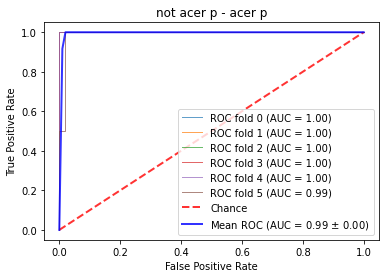

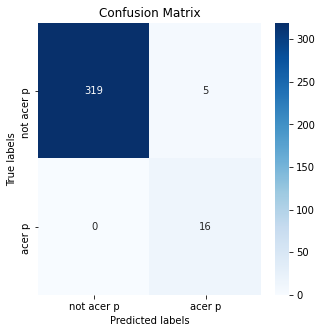

In [54]:
k_fold_svm_ovr(X, y, 6, 'linear', 11, ['not acer p', 'acer p'])

SVM - Linear
Runtime: 0.2321539339999994 seconds.


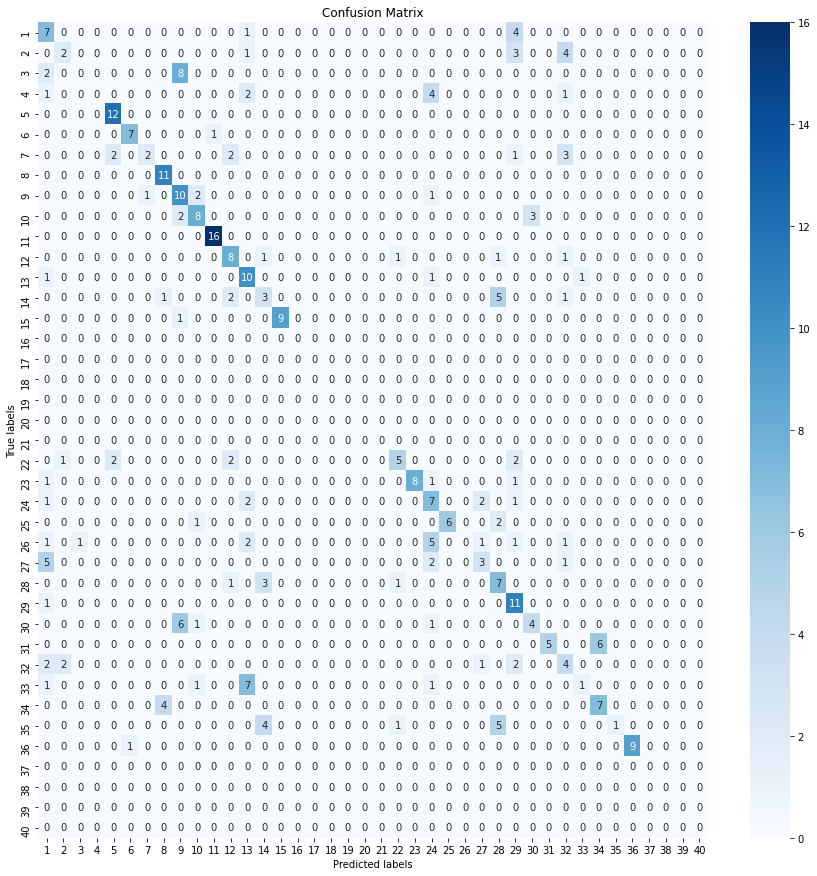

In [55]:
print('SVM - Linear')
k_fold_svm_multi(X, y, 6, 'linear', 1)

**PART 3 Comments:**

k is set to 6 to obtain best result by hand tuning.

**PART 4 Results: Classifier based on polynomial SVM**

Run time: 0.048023184000001606 seconds.


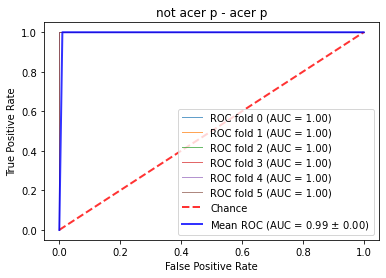

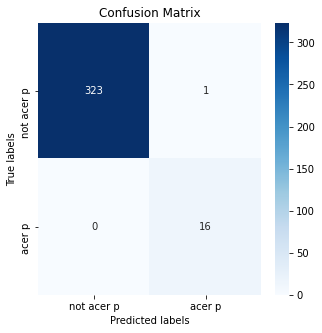

In [56]:
k_fold_svm_ovr(X, y, 6, 'poly', 11, ['not acer p', 'acer p'], 1, 3, 2)

SVM - Polynomial
Runtime: 0.256344600999995 seconds.


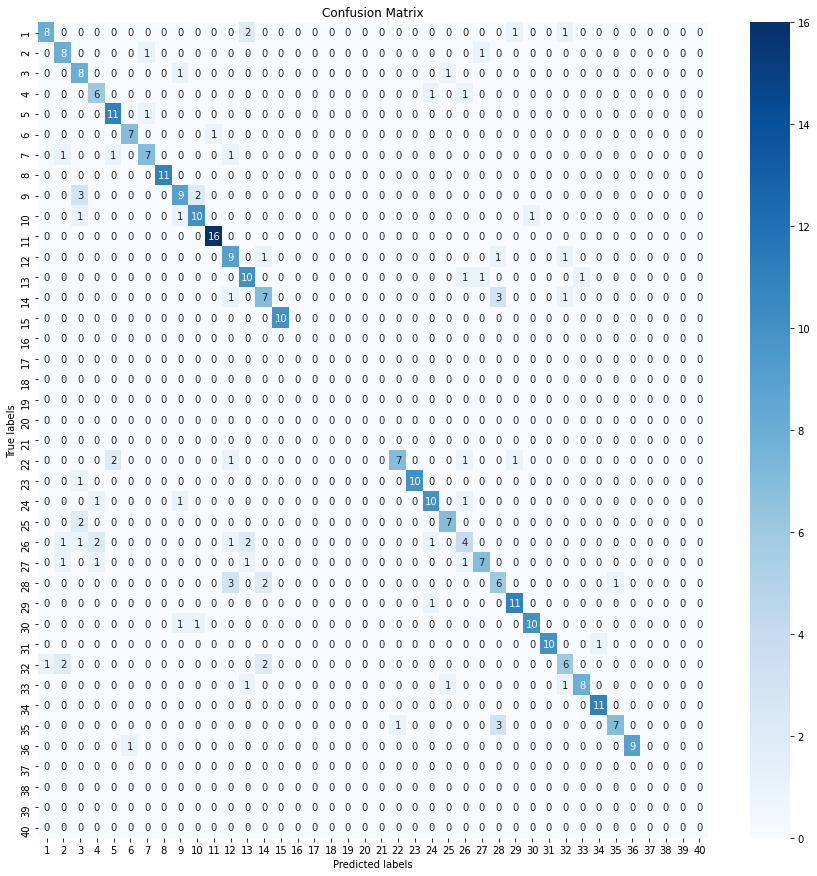

In [57]:
print('SVM - Polynomial')
k_fold_svm_multi(X, y, 6, 'poly', 1, 3, 2)

**Part 4 Comments:**

k is set to 6 to obtain best result by hand tuning.
c selected as 1 (0.01, 0.1, 1, 10, 100 values also tested)
Polynomial svm seems to give better fp rates. 